<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/EnsembleTests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook I want to test just the ensemble models to save time going forward because i do not beleive the simple rnn, cnn, or individual lstm models are worth testing because they dont capture whats happening very well

#Setup

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [2]:
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision

# ✅ Enable GPU & Force TensorFlow to Use It
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        print(f"✅ GPU detected: {gpu_devices[0].name} (Memory Growth Enabled)")
    except:
        print("⚠️ GPU found, but could not enable memory growth.")
else:
    print("❌ No GPU detected. Running on CPU.")

# ✅ Enable Mixed Precision for Faster Training (Uses float16 on GPU)
mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision Enabled (float16) for Faster GPU Training")

# ✅ Check GPU Usage Before Training
!nvidia-smi --query-gpu=memory.used,memory.total --format=csv

# ✅ Function to Monitor GPU Usage Live
def monitor_gpu():
    print("\n🔍 Checking GPU Usage...")
    os.system("nvidia-smi --query-gpu=memory.used,memory.total --format=csv")

monitor_gpu()


✅ GPU detected: /physical_device:GPU:0 (Memory Growth Enabled)
✅ Mixed Precision Enabled (float16) for Faster GPU Training
memory.used [MiB], memory.total [MiB]
2 MiB, 15360 MiB

🔍 Checking GPU Usage...


In [3]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

# Function to detect and list valid files
def get_valid_files():
    uploaded_files = os.listdir()  # List files in Colab's working directory
    pattern = re.compile(r"^([A-Za-z]+).*raw.*\.csv$", re.IGNORECASE)  # Matches ...raw...csv
    valid_files = {f: pattern.match(f).group(1).upper() for f in uploaded_files if pattern.match(f)}
    return valid_files

# Function to prompt user for file selection if multiple are found
def select_file():
    valid_files = get_valid_files()

    if not valid_files:
        print("❌ No valid raw stock data files found. Please upload one.")
        return None, None

    if len(valid_files) == 1:
        filename = list(valid_files.keys())[0]
        stock_ticker = valid_files[filename]
        print(f"✅ Automatically selected: {filename} ({stock_ticker})")
        return filename, stock_ticker

    # If multiple files, ask the user to select
    print("🔍 Multiple stock raw files detected. Please choose one:")
    for i, fname in enumerate(valid_files.keys()):
        print(f"{i + 1}. {fname} ({valid_files[fname]})")

    choice = int(input("Enter the number of the file to use: ")) - 1
    filename = list(valid_files.keys())[choice]
    stock_ticker = valid_files[filename]

    print(f"✅ Selected: {filename} ({stock_ticker})")
    return filename, stock_ticker

# Select file to process
file_name, ticker = select_file()

if file_name:
    # Load data
    df = pd.read_csv(file_name)

    # Drop rows with missing target values (Close Price)
    df = df.dropna(subset=['Close'])

    # Fill missing sentiment values with the last available value (forward fill)
    df[['sentiment_polarity', 'sentiment_subjectivity']] = df[['sentiment_polarity', 'sentiment_subjectivity']].ffill()

    # Drop any remaining NaN values
    df = df.dropna()

    # Convert Date to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # Select relevant features
    features = ['Open', 'High', 'Low', 'Volume', 'ATR', 'BB_High', 'BB_low', 'DC_High', 'DC_low',
                'KC_High', 'KC_Low', 'Williams_%R', 'sentiment_polarity', 'sentiment_subjectivity']
    target = ['Close']

    # Scaling
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_x.fit_transform(df[features])
    y_scaled = scaler_y.fit_transform(df[target])

    # Convert to sequences for LSTM/CNN
    sequence_length = 30
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_scaled[i+sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # Train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

    # Save scalers (Colab sidebar)
    joblib.dump(scaler_x, "scaler_x.pkl")
    joblib.dump(scaler_y, "scaler_y.pkl")

    # Save processed data
    np.save("X_train.npy", X_train)
    np.save("X_test.npy", X_test)
    np.save("y_train.npy", y_train)
    np.save("y_test.npy", y_test)

    print(f"✅ Preprocessing complete for {ticker}. Files saved:")
    print("- X_train.npy, X_test.npy, y_train.npy, y_test.npy")
    print("- scaler_x.pkl, scaler_y.pkl")
else:
    print("❌ No valid file selected. Exiting.")


✅ Automatically selected: spyraw.csv (SPY)
✅ Preprocessing complete for SPY. Files saved:
- X_train.npy, X_test.npy, y_train.npy, y_test.npy
- scaler_x.pkl, scaler_y.pkl


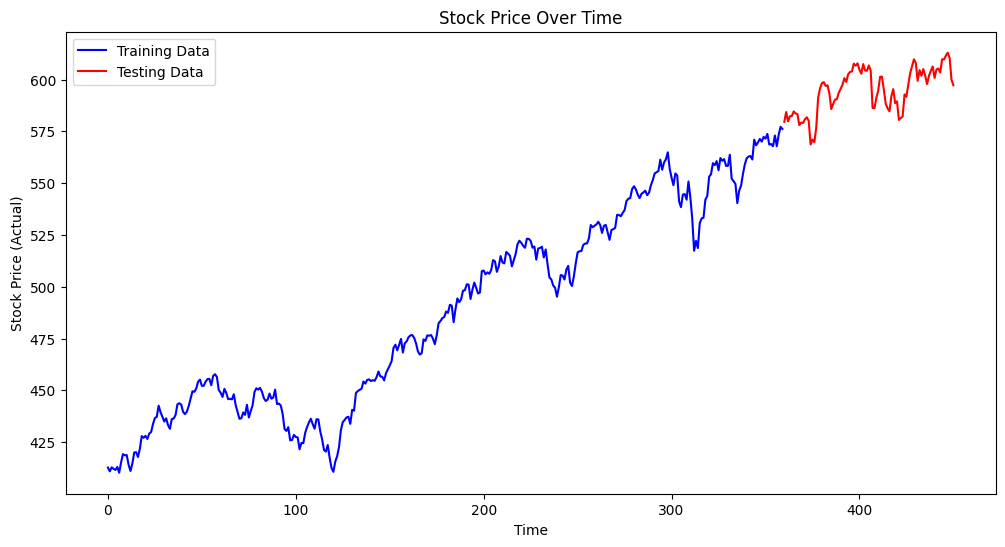

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Load preprocessed data from Colab sidebar
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Load scalers
scaler_y = joblib.load("scaler_y.pkl")

# Unscale target values (stock prices)
y_train_unscaled = scaler_y.inverse_transform(y_train)
y_test_unscaled = scaler_y.inverse_transform(y_test)

# Plot actual stock price vs time
plt.figure(figsize=(12,6))
plt.plot(y_train_unscaled, label="Training Data", color="blue")
plt.plot(range(len(y_train_unscaled), len(y_train_unscaled) + len(y_test_unscaled)), y_test_unscaled, label="Testing Data", color="red")
plt.xlabel("Time")
plt.ylabel("Stock Price (Actual)")
plt.title("Stock Price Over Time")
plt.legend()
plt.show()

#Ensemble Models

✅ Data Loaded: X_train shape: (360, 30, 14), y_train shape: (360, 1)
✅ X_test shape: (91, 30, 14), y_test shape: (91, 1)
✅ Old tuner files deleted. Restarting hyperparameter tuning...
Epoch 1/500
12/12 - 6s - 511ms/step - loss: 0.1136 - mae: 0.2265 - val_loss: 0.0024 - val_mae: 0.0398 - learning_rate: 5.0000e-04
Epoch 2/500
12/12 - 2s - 158ms/step - loss: 0.0073 - mae: 0.0684 - val_loss: 0.0026 - val_mae: 0.0411 - learning_rate: 5.0000e-04
Epoch 3/500
12/12 - 1s - 68ms/step - loss: 0.0052 - mae: 0.0554 - val_loss: 0.0116 - val_mae: 0.0992 - learning_rate: 5.0000e-04
Epoch 4/500
12/12 - 2s - 154ms/step - loss: 0.0041 - mae: 0.0490 - val_loss: 0.0044 - val_mae: 0.0555 - learning_rate: 5.0000e-04
Epoch 5/500
12/12 - 1s - 91ms/step - loss: 0.0034 - mae: 0.0447 - val_loss: 0.0059 - val_mae: 0.0664 - learning_rate: 5.0000e-04
Epoch 6/500

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
12/12 - 1s - 68ms/step - loss: 0.0021 - mae: 0.0365 - val_loss: 0.0060 - val_ma

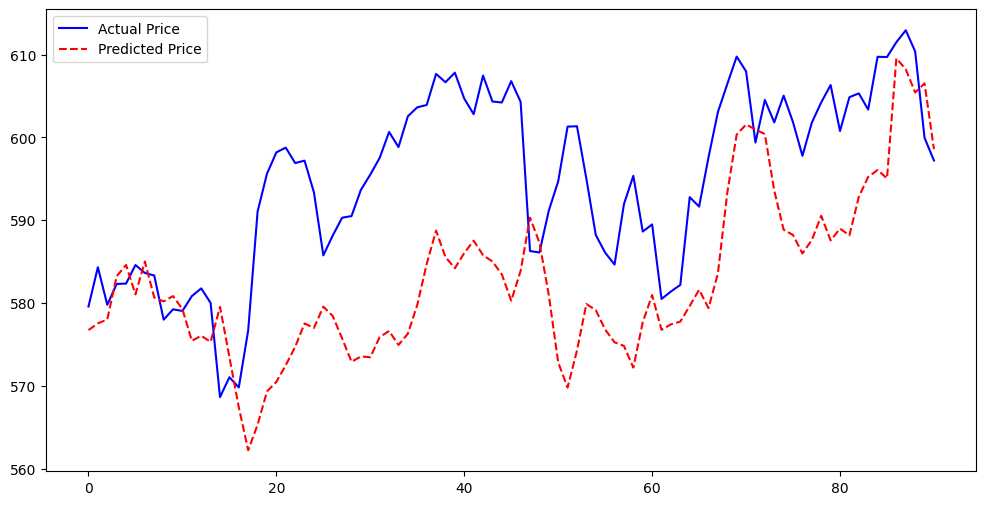

In [11]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import shutil  # ✅ For deleting old tuner files
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dense, Dropout, Concatenate, Multiply, BatchNormalization, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# === Define Model Save Path ===
ensemble_folder = "EnsembleModel2_CuDNN"
os.makedirs(ensemble_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# ✅ Ensure X_train is 3D
if len(X_train.shape) != 3:
    raise ValueError(f"❌ X_train should have 3 dimensions (samples, timesteps, features), but got {X_train.shape}")

# ✅ Delete old tuner files before running
tuner_dir = os.path.join(ensemble_folder, "tuning")
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)
    print("✅ Old tuner files deleted. Restarting hyperparameter tuning...")

# === Step 2: Hyperparameter Tuning ===
def build_ensemble_model(hp):
    """Builds an improved Ensemble Model combining CNN, RNN, and CuDNN-Optimized LSTM with Attention and Adaptive Weighted Fusion."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # === CNN Branch ===
    cnn = Conv1D(filters=hp.Choice('cnn_filters', [64, 128, 256]),
                 kernel_size=hp.Choice('cnn_kernel_size', [3, 5, 7]),
                 activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)
    cnn_weight = Dense(1, activation='sigmoid')(cnn)  # Adaptive weighting

    # === RNN Branch ===
    rnn = SimpleRNN(units=hp.Choice('rnn_units', [75, 100, 125]), return_sequences=True)(inputs)
    rnn = SimpleRNN(units=hp.Choice('rnn_units_2', [75, 100, 125]), return_sequences=True)(rnn)
    rnn = Attention()([rnn, rnn])
    rnn = Flatten()(rnn)
    rnn_weight = Dense(1, activation='sigmoid')(rnn)  # Adaptive weighting

    # === CuDNN-Optimized LSTM Branch ===
    lstm = LSTM(units=hp.Choice('lstm_units', [50, 75, 100]), return_sequences=True, activation='tanh', recurrent_activation='sigmoid')(inputs)
    lstm = LSTM(units=hp.Choice('lstm_units_2', [50, 75, 100]), return_sequences=True, activation='tanh', recurrent_activation='sigmoid')(lstm)
    lstm = Attention()([lstm, lstm])
    lstm = Flatten()(lstm)
    lstm_weight = Dense(1, activation='sigmoid')(lstm)  # Adaptive weighting

    # === Adaptive Weighted Fusion ===
    cnn_scaled = Multiply()([cnn, cnn_weight])
    rnn_scaled = Multiply()([rnn, rnn_weight])
    lstm_scaled = Multiply()([lstm, lstm_weight])

    merged = Concatenate()([cnn_scaled, rnn_scaled, lstm_scaled])
    merged = Dense(units=hp.Choice('dense_units', [50, 100, 150]), activation="relu")(merged)
    merged = Dropout(hp.Choice('dropout_rate', [0.1, 0.2, 0.3]))(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Initialize Tuner
tuner = kt.RandomSearch(
    build_ensemble_model,
    objective="val_loss",
    max_trials=10,  # Stability improvement
    executions_per_trial=3,
    directory=tuner_dir,
    project_name="stock_prediction_ensemble"
)

# ✅ Run Hyperparameter Tuning with Error Handling
best_hps = None
try:
    tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)  # Suppressed output
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
except Exception as e:
    print(f"⚠️ Hyperparameter tuning failed: {e}")
    print("⚠️ Using default parameters instead...")
    best_hps = {
        "cnn_filters": 128,
        "cnn_kernel_size": 5,
        "rnn_units": 100,
        "rnn_units_2": 100,
        "lstm_units": 75,
        "lstm_units_2": 75,
        "dense_units": 100,
        "dropout_rate": 0.2,
        "learning_rate": 0.0005
    }

# ✅ Train the Best Model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=2  # Shows only best loss & current loss
)

# ✅ Save the Best Model
best_model.save(os.path.join(ensemble_folder, "best_ensemble_model.keras"))

# ✅ Evaluate the Model
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# ✅ Plot Predictions
predictions_rescaled = scaler_y.inverse_transform(best_model.predict(X_test))
y_test_rescaled = scaler_y.inverse_transform(y_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.legend()
plt.show()
